# Sentimental Analysis of Amazon Reviews

## 1. Introduction

write some introduction here

### 1.1 About the Dataset

write about dataset here

### 1.2 Context

write context information

### 1.3 Dataset Content

write content of the dataset

## 2. Imports and Data Loading

### 2.1 Importing required modules

In [209]:
# Import required modules
import re
import lxml
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from nltk.corpus import stopwords 

from sklearn import naive_bayes
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay

### 2.2 Loading the database

In [210]:
#load the csv file
data = pd.read_csv('dataset/appl_1_amazon_pc.csv')

In [211]:
data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1


In [212]:
data.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'sentiment'],
      dtype='object')

In [213]:
# properties of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30846 entries, 0 to 30845
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        30846 non-null  object
 1   customer_id        30846 non-null  int64 
 2   review_id          30846 non-null  object
 3   product_id         30846 non-null  object
 4   product_parent     30846 non-null  int64 
 5   product_title      30846 non-null  object
 6   product_category   30846 non-null  object
 7   star_rating        30846 non-null  int64 
 8   helpful_votes      30846 non-null  int64 
 9   total_votes        30846 non-null  int64 
 10  vine               30846 non-null  object
 11  verified_purchase  30846 non-null  object
 12  review_headline    30844 non-null  object
 13  review_body        30842 non-null  object
 14  review_date        30846 non-null  object
 15  sentiment          30846 non-null  int64 
dtypes: int64(6), object(10)
memory usage: 3.

### 2.3 Data Cleaning

## 3. Sentiment Analysis and Visualization of the results

First, we need to assign labels to Amazon product reviews based on star ratings. Reviews with 5 or 4 stars are labeled as positive, while the rest are labeled as negative. This allows us to perform sentiment analysis on the reviews.

In [214]:
data['sentiment'] = np.where(data['star_rating'] == 5.0, 1,
                           np.where(data['star_rating'] == 4.0, 1, 0))

Now let's choose a particular product for analysis. This allows for a more focused and actionable understanding of customer sentiments

In [215]:
def get_particular_product(data, product_name):
    data = data.loc[data["product_title"] == product_name]
    return data

In [216]:
# Choose a particular product for analysis
selected_product = get_particular_product(data, 'Fire HD 7, 7" HD Display, Wi-Fi, 8 GB')


Now, we'll split into training and testing datasets for sentiment analysis of a specific product.

In [217]:
# Split the dataset into training and testing sets
reviews = selected_product['review_body']
sentiments = selected_product['sentiment']

X_train, X_test, y_train, y_test = train_test_split(reviews, sentiments, test_size=0.2, random_state=42)

### Preprocessing and Cleaning the dataset

Now raw text data needs to be preprocessed and cleaned before using it for training a sentiment analysis model. The preprocessing steps, such as removing HTML elements, special characters, converting to lowercase, and removing stopwords, help to standardize the text, remove noise, and focus on the most relevant information. By cleaning and preprocessing the data, we can improve the accuracy and effectiveness of the sentiment analysis model by providing it with a more refined and meaningful input.

In [218]:
# removes HTML elements and tags from the text
def removeHTML(raw_text):
    if isinstance(raw_text, str):
        clean_HTML = BeautifulSoup(raw_text, 'html.parser').get_text()
        return clean_HTML
    else:
        return raw_text

In [219]:
# removes special characters from the text
def removeSpecialChar(raw_text):
    if isinstance(raw_text, str):
        clean_SpecialChar = re.sub("[^a-zA-Z]", " ", raw_text)
        return clean_SpecialChar
    else:
        return str(raw_text)

In [220]:
# converts the text to lower case
def toLowerCase(raw_text):
    clean_LowerCase = raw_text.lower().split()
    return( " ".join(clean_LowerCase))  

In [221]:
# removes stop words from the text
def removeStopWords(raw_text):
    stops = set(stopwords.words("english"))
    words = [w for w in raw_text if not w in stops]
    return( " ".join(words))

In [222]:
# cleans data
def clean_data(data):
    cleaned_data = []
    
    for text in data:
        text = removeHTML(text)
        text = removeSpecialChar(text)
        text = toLowerCase(text)
        removeStopWords(text)
        cleaned_data.append(text)
    
    return cleaned_data

In [223]:
# stores the cleaned training text in a list
cleaned_X_train = clean_data(X_train)

C:\Users\ibsaa\AppData\Local\Temp\ipykernel_6956\3698073279.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_HTML = BeautifulSoup(raw_text, 'html.parser').get_text()


In [224]:
# X_testing clean set
cleaned_X_test = clean_data(X_test)

C:\Users\ibsaa\AppData\Local\Temp\ipykernel_6956\3698073279.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_HTML = BeautifulSoup(raw_text, 'html.parser').get_text()


### TF-IDF Feature Extraction

- TF-IDF feature extraction is used to convert the raw textual reviews into a numerical representation. This technique considers the frequency of words in each review (term frequency, TF) and the rarity of words across all reviews (inverse document frequency, IDF).
- In our case, TF-IDF feature extraction is applied to capture the relevance and distinctiveness of words in the reviews, improving the accuracy of sentiment analysis on Amazon product data.

In [225]:
# create a TF-IDF vectorizer object
tvec = TfidfVectorizer(use_idf=True, strip_accents='ascii')

# fit and transform the preprocessed training data into TF-IDF features
X_train_tvec = tvec.fit_transform(cleaned_X_train)
X_test_tvec = tvec.transform(cleaned_X_test)

### 3.1 Support Vector Classifier (SVC) Model

In [226]:
#svc model
svc_model = LinearSVC(multi_class='ovr',C=1.0,loss='squared_hinge', dual=False)
svc_model.fit(X_train_tvec, y_train)

LinearSVC(dual=False)

In [227]:
# Predict using testing data and generate classification report
svc_predictions = svc_model.predict(X_test_tvec)
classification_report_svc = classification_report(y_test, svc_predictions, output_dict=True)
classification_report_df = pd.DataFrame(classification_report_svc).transpose().round(2)

In [228]:
cm = sns.light_palette("yellow", as_cmap=True)
classification_report_df.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.770000,0.630000,0.690000,1018.000000
1,0.930000,0.960000,0.950000,5152.000000
accuracy,0.910000,0.910000,0.910000,0.910000
macro avg,0.850000,0.800000,0.820000,6170.000000
weighted avg,0.900000,0.910000,0.900000,6170.000000


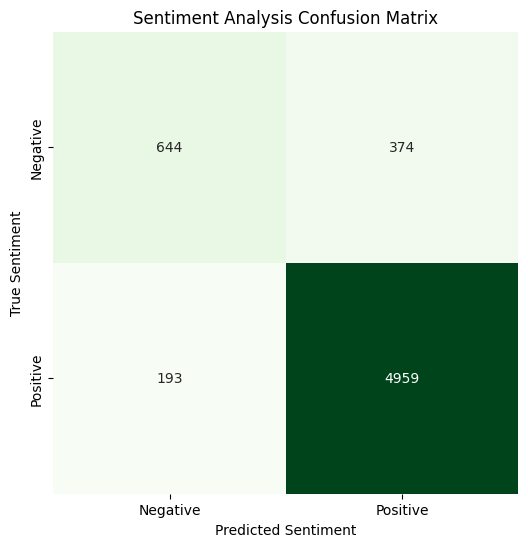

In [229]:
# Plot confusion matrix
confusion_matrix_result = confusion_matrix(y_test, svc_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_result, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Sentiment Analysis Confusion Matrix')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
plt.show()

Based on the classification report:

- For class 0 (negative sentiment), the precision is 0.77, recall is 0.63, and F1-score is 0.69. This suggests that the classifier performs reasonably well in identifying negative sentiment, but there is room for improvement.
- For class 1 (positive sentiment), the precision is 0.93, recall is 0.96, and F1-score is 0.95. These metrics indicate that the classifier is performing very well in identifying positive sentiment.
- The accuracy of the classifier is 0.91, which is the overall percentage of correct predictions on the test data.

The confusion matrix provides a more detailed breakdown of the classifier's predictions:

- True Negative (TN): 644 instances were correctly predicted as negative sentiment.
- False Positive (FP): 374 instances were incorrectly predicted as positive sentiment.
- False Negative (FN): 193 instances were incorrectly predicted as negative sentiment.
- True Positive (TP): 4959 instances were correctly predicted as positive sentiment.

The confusion matrix helps in evaluating the classifier's performance and understanding the types of errors it makes.

In [230]:
def predict_sentiment_svc(review):
    # Transform the review using the TF-IDF vectorizer
    review_tvec = tvec.transform([review])
    
    # Make a prediction using the SVC model
    sentiment = svc_model.predict(review_tvec)
    
    # Return the predicted sentiment
    if sentiment[0]:
        return 'Positive'
    return 'Negative'

In [231]:
# Test the model with a sample Negative review
demo_review = 'Three days of use and it broke. Very disappointed in this product. It worked perfectly for exactly three days and could not be resuscitated. \
               It was very inexpensive, so I did not want to pay half again the price to ship it back for an exchange. \
               The company would do nothing when they sent me an inquiry as to product satisfaction.'

predicted_sentiment = predict_sentiment_svc(demo_review)
print("Predicted Sentiment:", predicted_sentiment)

Predicted Sentiment: Negative


In [232]:
demo_review_2 = "Excellent product. Works well and performs as expected. I would recommend this product to anyone looking for a tablet."
predicted_sentiment_2 = predict_sentiment_svc(demo_review_2)
print("Predicted Sentiment:", predicted_sentiment_2)

Predicted Sentiment: Positive


### 3.2 Random Forest Model

In [233]:
# Random Forest model
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_tvec, y_train)

RandomForestClassifier()

In [234]:
# Predict using testing data and generate classification report
rainforest_predictions = random_forest_model.predict(X_test_tvec)
classification_report_rf = classification_report(y_test, rainforest_predictions, output_dict=True)
classification_report_rf_df = pd.DataFrame(classification_report_rf).transpose().round(2)

In [235]:
# display the classification report
cm = sns.light_palette("red", as_cmap=True)
classification_report_rf_df.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.840000,0.290000,0.430000,1018.000000
1,0.880000,0.990000,0.930000,5152.000000
accuracy,0.870000,0.870000,0.870000,0.870000
macro avg,0.860000,0.640000,0.680000,6170.000000
weighted avg,0.870000,0.870000,0.850000,6170.000000


array([[ 299,  719],
       [  58, 5094]], dtype=int64)

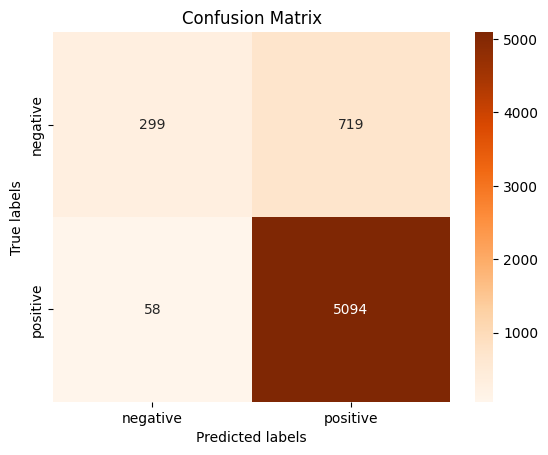

In [238]:
# confusion matrix
ranfrst_predictions=random_forest_model.predict(tvec.transform(cleaned_X_test))
ax= plt.subplot()
cm=confusion_matrix(y_test,ranfrst_predictions)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Oranges');  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive'])
cm

Here's the analysis for the Random Forest Model

Precision:

- For the "Negative" class (0), the precision is 0.84, indicating that 84% of the predicted "Negative" reviews are actually negative.
- For the "Positive" class (1), the precision is 0.88, meaning that 88% of the predicted "Positive" reviews are actually positive.

Recall:

- For the "Negative" class (0), the recall is 0.29, indicating that only 29% of the actual negative reviews are correctly identified as negative.
- For the "Positive" class (1), the recall is 0.99, meaning that 99% of the actual positive reviews are correctly identified as positive.

F1-score:

- For the "Negative" class (0), the F1-score is 0.43, which is the harmonic mean of precision and recall for the negative class.
- For the "Positive" class (1), the F1-score is 0.93, representing the harmonic mean of precision and recall for the positive class.

Support:

- The "Negative" class has a support of 1018, indicating the number of samples in the testing data classified as negative.
- The "Positive" class has a support of 5152, representing the number of samples classified as positive.

Accuracy:

- The overall accuracy of the model is 0.87, indicating that 87% of the reviews in the testing data are correctly classified.

Confusion Matrix:

- The confusion matrix shows the counts of true positive, false positive, true negative, and false negative predictions.
- In this case, there are 299 true negative predictions, 719 false positive predictions, 58 false negative predictions, and 5094 true positive predictions.

### 3.3 Analysis 3

### 3.4 Analysis 4

### 3.5 Analysis 5

## 4. Conclusion

## 5. Future Suggestion